학습과정은 생략하고, 추론 과정만 구현해보도록 한다. 데이터셋은 유명한 MNIST 데이터셋이다.

# 3.6.1 MNIST 데이터셋

* 기계학습에서 매우 유명한 데이터셋
* 0 ~ 9의 숫자 이미지들로 구성
* shape: 28 x 28 x 1
* train 6만장, test 1만장

책에서는 깃허브에서 가져오라고 하는데, 그러지 말고 그냥 keras에 내장되어 있는 함수를 이용해본다. 왜냐면 편하기 때문이다.

In [17]:
import keras.datasets.mnist as mnist

dataset = mnist.load_data()

In [27]:
len(dataset)
len(dataset[0])
len(dataset[0][0]) # train_x
len(dataset[0][1]) # train_y
len(dataset[1][0])
dataset[1][1].shape

(10000,)

데이터셋을 살펴보는 Tip

* len함수를 이용하여 몇 개로 나눠지는지 확인하기
* ? 기호를 이용하여, 변수에 어떻게 할당할지 구상해보기
* shape를 이용하여 모양 살펴보기

In [4]:
# len(dataset)
# len(dataset[0])
# ?mnist.load_data

In [40]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [37]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


load_data의 다양한 파라미터값 직접 구현해보기

* 데이터값의 범위 확인하기 -> np.max vs max
* 255까지 데이터가 있으면, 정규화 해주기.

In [32]:
import numpy as np

np.max(train_x) # min도 해보기
# max(train_x)

0

In [41]:
train_x = train_x / 255.
train_x = train_x.astype(np.float32)
# print(train_x.dtype)

In [42]:
train_x.dtype

dtype('float32')

flatten 살펴보기

In [43]:
f_train_x = train_x.flatten()
f_train_x.shape

(47040000,)

In [44]:
28 * 28 * 60000

47040000

one-hot 인코딩 살펴보기

* 라벨값의 인덱스만 1이고, 나머지는 0인 것을 원핫 인코딩이라고 부른다.
* 직접 구현해 본다면?

In [46]:
train_y

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [49]:
def onehot(num, maxnum):
    return np.array([1 if i == num else 0 for i in range(maxnum)])

In [50]:
onehot(5, 10)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [51]:
import sys, os
sys.path.append(os.pardir) # 한폴더 위의 경로를 환경변수에 추가
import numpy as np
from keras.datasets.mnist import load_data
from PIL import Image

def img_show(img):
    pil_image = Image.fromarray(np.int8(img))
#     pil_image = Image.fromarray(img)
    pil_image.show()

In [52]:
(train_x, train_y), (test_x, test_y) = load_data()
img = train_x[0]
label = train_y[0]
print(label)

5


In [53]:
print(img.shape)
img_show(img)

(28, 28)


책에 나온 방법모다는 matplotlib 라이브러리를 사용하는게 깔끔하다. 책에서는 flatten을 쓰느라 다시 reshape를 해주었는데, 우리는 그냥 읽어들였으므로 별도의 reshape를 하지 않는다.

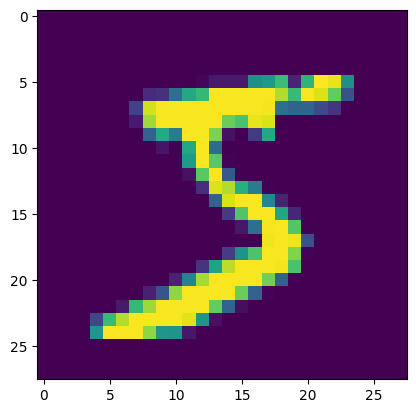

In [56]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

# 3.6.2 신경망의 추론 원리

이제 mnist 데이터셋으로 신경망을 구현해보자.

* 입력층: 784 뉴런 (28 x 28)
* 출력층: 10 뉴런

가중치는 미리 저장된 것을 불러다 읽는다. 이건 어쩔 수 없이 깃허브에서 받아와야 할 듯 하다.

In [14]:
import pickle
from lib.activation import sigmoid, softmax, softmax2

def get_data():
    (train_x, train_y), (test_x, test_y) = load_data()
    train_x = train_x.reshape(-1, 784) / 255.
    test_x = test_x.reshape(-1, 784) / 255.

    # train_x = train_x.flatten() / 255.
    # test_x = test_x.flatten() / 255.
    return test_x, test_y

def init_network():
    with open("lib/sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    # print('input shape:', b1.shape)

    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)

    return y

In [61]:
x, lb = get_data()
network = init_network()
accuracy_cnt = 0

for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y)
    if p == lb[i]:
        accuracy_cnt += 1

In [64]:
accuracy_cnt / 10000 * 100

93.52000000000001

# 3.6.3 배치 처리

<p align="center"><img src="imgs/3-26.png" width=500></p>

가중치 매개변수의 형상을 살펴보고, 조금 전의 구현을 다시 해본다. 행렬에서 앞/뒤의 차원 수가 일치해야 행렬의 곱셈이 성립된다는 사실을 알고 있을 것이다. 결국 행렬의 곱셈이 많아지면, 젤 앞의 차원과 맨 뒤의 차원만 남게 되는 형태로 바뀐다. 위의 그림은 이미지가 1장일 때와 100장일 때의 처리를 보여준다.

In [65]:
x, _ = get_data()
network = init_network()
W1, W2, W3 = network['W1'], network['W2'], network['W3']

In [67]:
print(x.shape)
print(x[0].shape, W1.shape, W2.shape, W3.shape)

(10000, 784)
(784,) (784, 50) (50, 100) (100, 10)


이렇게 이미지를 100장이든 몇 장이든 다발로 묶어 처리하는 방식을 배치(batch)라고 한다. 보통 배치는 2의 제곱 수를 많이 사용한다. 책에서는 100이라고 했지만, 실제로 학습에서는 2, 4, 8, 16 등을 더 많이 사용하게 될 것이다. 이제 배치 처리를 구현해보도록 하자.

In [73]:
x, lb = get_data()
network = init_network()

batch_size = 100
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch)
    p = np.argmax(y_batch, axis=1)
    accuracy_cnt += np.sum(p == lb[i:i+batch_size])

print('accuracy:', accuracy_cnt/len(x))

accuracy: 0.9352


range 부분을 유념해서 보자. 0부터 len(x)까지 반복하는데, 단위를 배치사이즈만큼 반복한다는 뜻이다. 그러니 첫 번재 단위는 0부터 99까지가 될 것이고, 두 번째 단위는 100부터 199까지가 되는 식이다. 아래 코드를 보면 이해가 된다.

In [75]:
print(list(range(0, 10)))
print(list(range(0, 10, 3)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 3, 6, 9]


다음으로는 argmax에 대해 살펴본다. argmax는 최댓값의 인덱스를 가져온다. argmax에 axis라는 파라미터는 어떤 축을 기준으로 계산할 것인지를 결정한다. 1이라는 것은 인덱스가 1인 축을 말하는데, 차원으로 치면 2번째 차원을 기준으로 최대 인덱스를 뽑겠다는 의미이다. 첫 번째 차원을 기준으로 하고 싶다면, axis = 0 으로 설정해주면 된다.

In [82]:
x = np.array([[0.1, 0.8, 0.1], 
              [0.3, 0.1, 0.6]])
print(x.shape)
y = np.argmax(x, axis = 1) # axis를 0으로도 바꿔보자
print(y)

(2, 3)
[1 2]


마지막으로 np.sum에 대해 살펴보자. 이는 배열에서 True인 것들을 세준다. 이는 파이썬에서 bool 값에 int가 할당된 원리를 이용한 것이다. 파이썬에서 True는 1이고 False는 0이다. 그러니 sum을 해주면, 자연스럽게 1인 요소들의 합이 구해지는 것이다.

In [85]:
print(int(True), int(False))

1 0


In [87]:
y = np.array([1, 2, 1, 0])
t = np.array([1, 2, 0, 0])
print(y==t)
print(np.sum(y==t))

[ True  True False  True]
3
